# Annulus

## 0 Packages

In [25]:
from dolfinx.io import gmshio
from mpi4py import MPI
from dolfinx import fem, plot, mesh, io
from dolfinx.fem.petsc import LinearProblem
from basix.ufl import element, mixed_element
import pyvista
from ufl import TestFunction, TrialFunction, FacetNormal, Identity, grad, div, inner, dx, ds, transpose, dot, as_vector, outer, lhs, rhs, TestFunctions, TrialFunctions, split, nabla_grad
pyvista.set_jupyter_backend("static")
import numpy as np
from petsc4py import PETSc
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc, NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver

## 1 Generate mesh

It's easier for me to use the gmsh GUI to generate mesh. Much less code and can see how the mesh evolves with edits. I will use this method for future mesh generation.

In [2]:
# load from .msh file
mesh_file = "annulus.msh"
domain, cell_tags, facet_tags = gmshio.read_from_msh(mesh_file, MPI.COMM_WORLD, 0, gdim=2)

Info    : Reading 'annulus.msh'...
Info    : 5 entities
Info    : 59 nodes
Info    : 118 elements
Info    : Done reading 'annulus.msh'


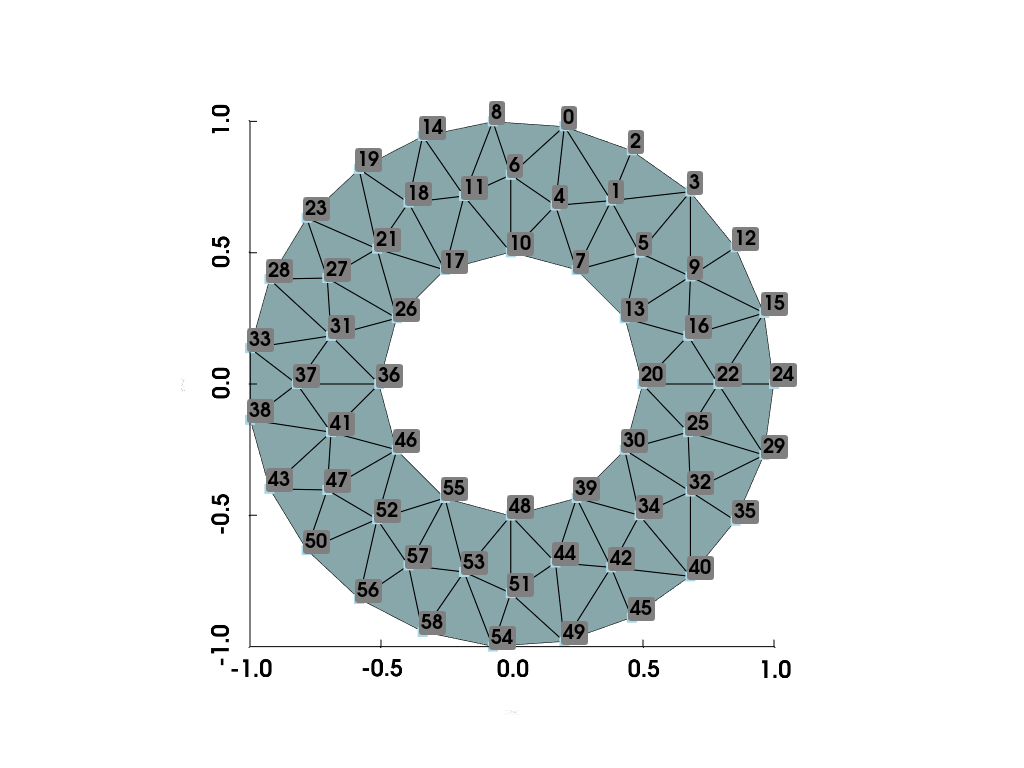

In [3]:
vtk_mesh = plot.vtk_mesh(domain)
grid = pyvista.UnstructuredGrid(*vtk_mesh)
pl = pyvista.Plotter()
pl.add_mesh(grid, show_edges=True)
pl.add_point_labels(grid.points, [str(i) for i in range(grid.n_points)], point_size=10, font_size=20)
pl.camera_position = 'xy'
pl.show_bounds()
pl.show()

## 2 Theoretical formulation

1. Momentum Conservation

$$
-\nabla^2 \mathbf{u} + \nabla P = \alpha \nabla\cdot Q
$$

$$
\nabla\cdot \mathbf{u} = 0
$$

2. Q-tensor Evolution

$$
\partial_t \mathbf{Q} + \mathbf{u}\cdot\nabla\mathbf{Q} = \mathbf{Q\Omega-\Omega Q} + \lambda\mathbf{E} + \gamma^{-1}\mathbf{H}
$$

where
- $\mathbf{E} = (\nabla\mathbf{u}+\nabla\mathbf{u}^T)/2$ is the strain rate tensor 
- $\mathbf{\Omega} = (\nabla\mathbf{u}-\nabla\mathbf{u}^T)/2$ is the vorticity tensor
- $\mathbf{H} = -\delta\mathcal{F}  / \delta \mathbf{Q}$ is the molecular field
- $\lambda$: flow-alignment parameter
- $\gamma$: rotational viscosity

3. Landau - de Gennes functional

$$
\mathcal{F}_\mathrm{bulk} = \int_\Omega \left( \frac{Cb_1}{2}\mathbf{Q:Q} + \frac{Cb_2}{4}(\mathbf{Q:Q})^2 + \frac{K}{2}\nabla\mathbf{Q}:\nabla\mathbf{Q}  \right) dV
$$

Surface anchoring

$$
\mathcal{F}_\mathrm{surf} = \int_{\partial\Omega} \frac{1}{2} E_A (\mathbf{Q} -\mathbf{Q}^{(b)}):(\mathbf{Q} -\mathbf{Q}^{(b)}) dS
$$

In [4]:
# domain = mesh.create_unit_square(comm=MPI.COMM_WORLD, nx=3, ny=3)
# Define individual elements
# Define function spaces
p_el = element("Lagrange", domain.topology.cell_name(), 1)            # pressure
u_el = element("Lagrange", domain.topology.cell_name(), 2, shape=(2,))
Q_el = element("Lagrange", domain.topology.cell_name(), 1, shape=(2, 2))     # velocity
uvis_el = element("Lagrange", domain.topology.cell_name(), 1, shape=(2,))  # velocity visualization
mix_pu = mixed_element([p_el, u_el])

W_pu = fem.functionspace(domain, mix_pu)
# V_p = fem.functionspace(domain, p_el)
# V_u = fem.functionspace(domain, u_el)
V_Q = fem.functionspace(domain, Q_el)
V_uvis = fem.functionspace(domain, uvis_el)

In [ ]:
p, u = TrialFunctions(W_pu)
q, v = TestFunctions(W_pu)
Q, phi = TrialFunction(V_Q), TestFunction(V_Q)
dQ = 

In [6]:
V_p, _ = W_pu.sub(0).collapse()
V_u, _ = W_pu.sub(1).collapse()

In [7]:
# previous time step
# V_p, V_u = split(W_pu)
w_ = fem.Function(W_pu)
p_n = fem.Function(V_p)
u_n = fem.Function(V_u)
Q_n = fem.Function(V_Q)
p_ = fem.Function(V_p)
u_ = fem.Function(V_u)
Q_ = fem.Function(V_Q)
uvis = fem.Function(V_uvis)

In [8]:
def walls(x):
    return np.logical_or(np.isclose(np.linalg.norm(x, axis=0), .5), np.isclose(np.linalg.norm(x, axis=0), 1.0))
facets = mesh.locate_entities(domain, 0, walls)

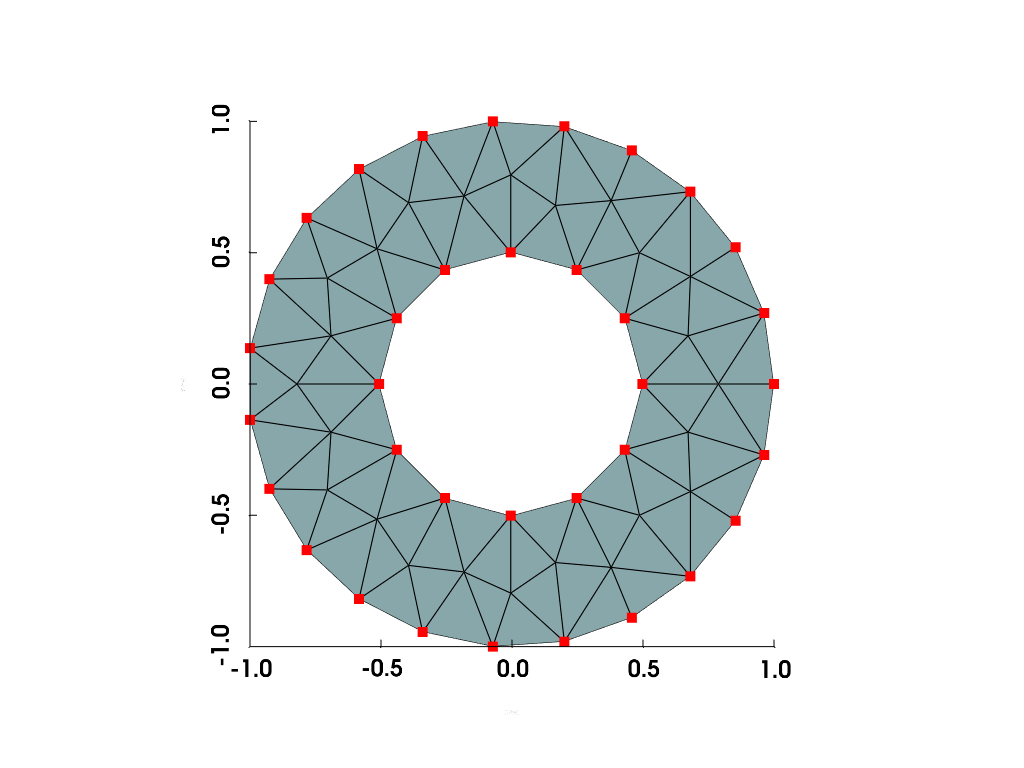

In [9]:
vtk_mesh = plot.vtk_mesh(domain)
grid = pyvista.UnstructuredGrid(*vtk_mesh)
pl = pyvista.Plotter()
pl.add_mesh(grid, show_edges=True)
pl.add_points(grid.points[facets], point_size=10, color='red')
# pl.add_points(grid.points[outer_facets], point_size=10, color='blue')
pl.camera_position = 'xy'
pl.show_bounds()
pl.show()

Define the initial conditions:

- pressure: all 0
- velocity: all 0
- Q-tensor: director d perpendicular to the radial direction

In [10]:
p_n.x.array[:] = 0
u_n.x.array[:] = np.random.rand(u_n.x.array.size)

In [11]:
# Get the mesh coordinates
x = domain.geometry.x  # shape (n_points, 2)
r = np.sqrt(x[:, 0]**2 + x[:, 1]**2)
# Avoid division by zero (if any points are at the origin)
r[r < 1e-10] = 1.0

# Compute the tangent (director) d = (-y, x)/|r|
d = np.column_stack((-x[:, 1], x[:, 0])) / r[:, None]

# Define the order parameter (set S=1)
S = 1.0
# Compute the Q-tensor: Q = S*(d⊗d - I/2)
Q_vals = S * (np.einsum("ni,nj->nij", d, d) - 0.5 * np.eye(2))

# Reshape Q_vals to match the flattened dolfinx Function vector and set Q_n
Q_n.x.array[:] = Q_vals.flatten()

In [136]:
Q_n.x.array.shape

(236,)

In [142]:
d = np.random.rand(x.shape[0], 2)

In [147]:
d /= np.linalg.norm(d, axis=1, keepdims=True)

In [148]:
np.linalg.norm(d, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [137]:
x.shape

(59, 3)

In [118]:
F1 = (
    inner(nabla_grad(u), nabla_grad(v)) * dx
    - p * div(v) * dx
    + q * div(u) * dx
    + inner(div(Q_n), v) * dx
)

In [119]:
wall_dofs = fem.locate_dofs_geometrical(V_p, walls)
noslip = fem.dirichletbc(PETSc.ScalarType(0), wall_dofs, V_p)
bcu = [noslip]

In [120]:
a1 = fem.form(lhs(F1))
L1 = fem.form(rhs(F1))

In [121]:
# assemble matrix A and b
A1 = assemble_matrix(a1)
A1.assemble()
b1 = create_vector(L1)

In [122]:
# configure a solver for u
solver1 = PETSc.KSP().create(domain.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

In [123]:
dt = 1

In [124]:
t = 0
t += dt
with b1.localForm() as loc_b:
    loc_b.set(0)
# b1.set(0)
assemble_vector(b1, L1)
apply_lifting(b1, [a1], [bcu])
b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
set_bc(b1, bcu)
solver1.solve(b1, w_.x.petsc_vec)

In [110]:
w_.x.array.shape

(461,)

In [125]:
p_sol, u_sol = w_.split()

In [126]:
u_.interpolate(u_sol)

In [132]:
uvis.interpolate(u_sol)

In [135]:
xdmf = io.XDMFFile(domain.comm, "annulus.xdmf", "w")
xdmf.write_mesh(domain)
xdmf.write_function(uvis, t)
xdmf.close()

In [111]:
u_.x.array.shape

(461,)

In [112]:
p_n.x.array.shape

(59,)

In [12]:
def q_to_director(Q):
    """
    Convert a Q-tensor (2x2 symmetric, traceless) of the form Q = S*(d⊗d - I/2)
    to the corresponding unit director d.
    
    Parameters:
      Q (numpy.ndarray): 2x2 Q-tensor.
    
    Returns:
      numpy.ndarray: Unit director, a vector of length 2.
    """
    Q11 = Q[0, 0]
    Q12 = Q[0, 1]
    norm = np.sqrt(Q11**2 + Q12**2)
    if norm < 1e-10:
        raise ValueError("Q-tensor magnitude is nearly zero; director is undefined.")
    theta = 0.5 * np.arctan2(Q12, Q11)
    d = np.array([np.cos(theta), np.sin(theta), 0])
    return d

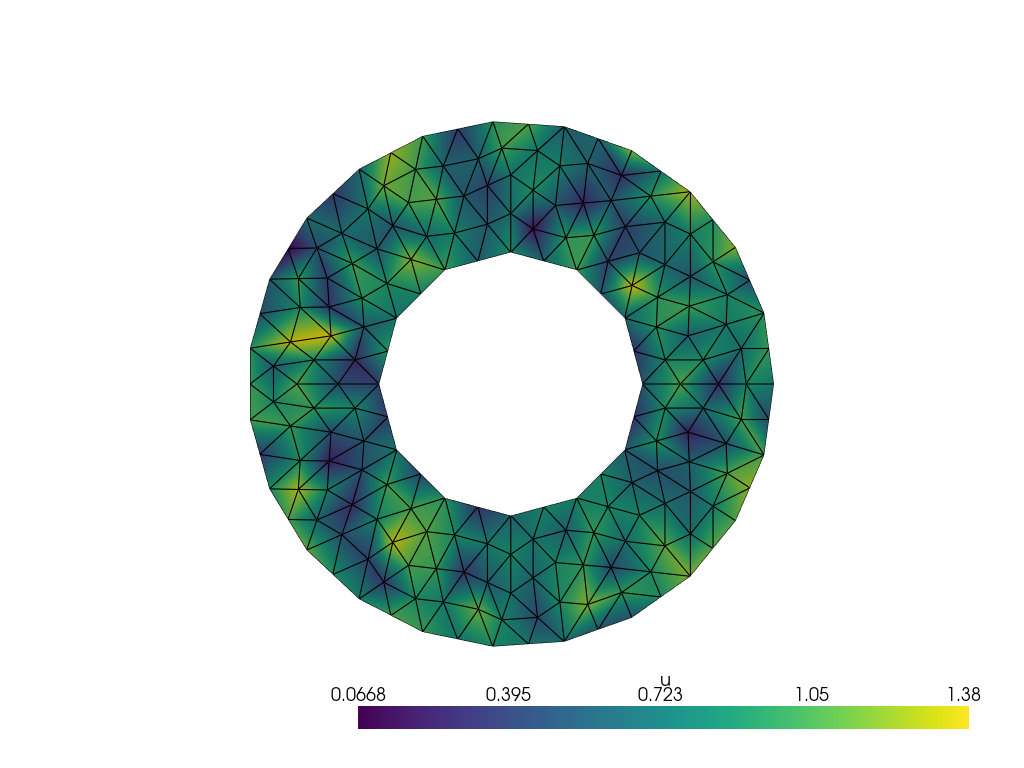

In [13]:
topology, cell_types, geometry = plot.vtk_mesh(V_u)
gridu = pyvista.UnstructuredGrid(topology, cell_types, geometry)
gridu.point_data["u"] = u_n.x.array.reshape((-1, 2))
pl = pyvista.Plotter()
pl.add_mesh(gridu, show_edges=True)
pl.camera_position = 'xy'
pl.show()

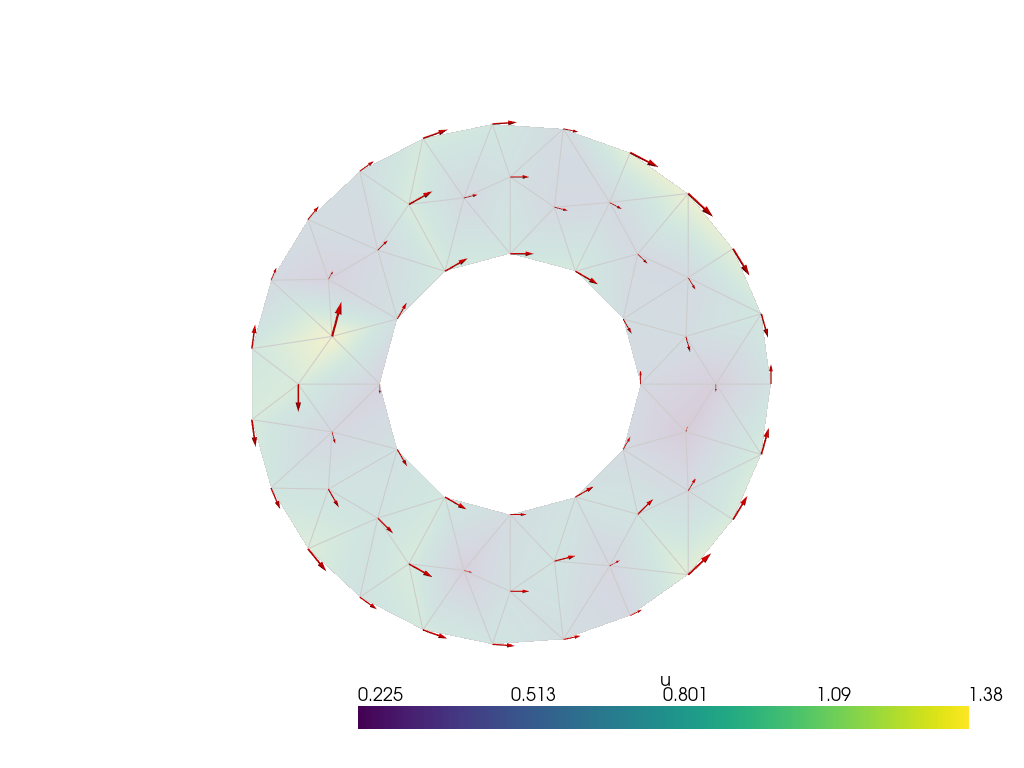

In [ ]:
# Reshape Q_n to get an array of 2x2 tensors (one per node)
Q_vals = Q_n.x.array.reshape(-1, 2, 2)

# Pad each 2x2 Q tensor to a 3x3 tensor (embed in the xy-plane)
Q_tensor_3d = np.zeros((Q_vals.shape[0], 3, 3))
Q_tensor_3d[:, :2, :2] = Q_vals

# Add Q tensor data to the existing grid as a flat 9-component array per point
grid.point_data["Q_tensor"] = np.array([q_to_director(Q) for Q in Q_vals])
V_u_vis = fem.functionspace(domain, ("Lagrange", 1, (2,)))
u_vis = fem.Function(V_u_vis)
u_vis.interpolate(u_n)
u_val = np.linalg.norm(u_vis.x.array.reshape(-1, 2), axis=1)
grid.point_data["u"] = u_val
grid.set_active_scalars("u")
grid.set_active_vectors("Q_tensor")
p.arctan2(Q12, Q11)

# Create tensor glyphs for visualization; adjust scale_factor as needed
glyphs = grid.glyph(factor=0.1)

# Plot the base mesh (with slight opacity) and overlay the glyphs
pl = pyvista.Plotter()
pl.add_mesh(grid, opacity=0.2, show_edges=True)
pl.add_mesh(glyphs, color="red")
pl.camera_position = 'xy'
pl.show()

In [141]:
domain.topology.create_connectivity(0, 2)

In [27]:
# p_dof = fem.locate_dofs_topological(V_p, 0, np.concat([inner_facets, outer_facets]))
# u_dof = fem.locate_dofs_topological(V_u, 0, np.concat([inner_facets, outer_facets]))
# q_dof = fem.locate_dofs_topological(V_Q, 0, np.concat([inner_facets, outer_facets]))
p_dof = fem.locate_dofs_geometrical(V_p, walls)
u_dof = fem.locate_dofs_geometrical(V_u, walls)
q_dof = fem.locate_dofs_geometrical(V_Q, walls)

In [28]:
u_bc = fem.dirichletbc(fem.Constant(domain, (0.0, 0.0)), u_dof, V_u)

In [12]:
# compute Qb to use as an implicit boundary condition in the variational form
n = FacetNormal(domain) # 'domain' is your mesh object
t_hat = as_vector((-n[1], n[0])) # Assuming 2D
I = Identity(domain.geometry.dim) # For 2D, this is a 2x2 identity tensor
Qb = outer(t_hat, t_hat) - 0.5 * I

In [13]:
T = 10
n_steps = 100
dt = T / n_steps

In [14]:
# Constants
alpha = fem.Constant(domain, PETSc.ScalarType(5.0))
mu = fem.Constant(domain, PETSc.ScalarType(1.0))
gamma = fem.Constant(domain, PETSc.ScalarType(1.0))
lambda_ = fem.Constant(domain, PETSc.ScalarType(0.7))
DE = fem.Constant(domain, PETSc.ScalarType(1.0))
Dr = fem.Constant(domain, PETSc.ScalarType(1.0))
beta1 = fem.Constant(domain, PETSc.ScalarType(0.6))
beta2 = fem.Constant(domain, PETSc.ScalarType((1.6 + 1.0) / (1.6**2)))
EA = fem.Constant(domain, PETSc.ScalarType(0.01))
k = fem.Constant(domain, PETSc.ScalarType(dt))

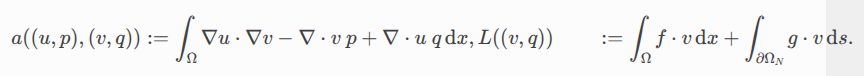

Combine the equations just by adding together

Weak form of the Stokes equation

$$
\int_\Omega (-\mu\nabla u:\nabla v + P\nabla\cdot v - \alpha (\nabla\cdot Q)\cdot v) \,d\Omega = 0
$$

$$
\int_\Omega (\nabla\cdot u) q \,d\Omega = 0
$$

$$
\left<-\mu\nabla u, \nabla v \right> + p\left<n, v\right>_{\partial\Omega} = \left< \alpha n\cdot Q, v\right>_{\partial\Omega}
$$

$$
q\left< n, u \right>_{\partial\Omega} = 0
$$

Weak form of the Q-tensor evolution

$$
\int_\Omega [\partial_t \mathbf{Q:\Phi} + (\mathbf{u}\cdot\nabla\mathbf{Q}):\Phi] \,d\Omega = \int_\Omega \left[ (\mathbf{Q\Omega - \Omega Q}):\mathbf{\Phi} + \lambda \mathbf{E:\Phi} + \gamma^{-1}\mathbf{H:\Phi}  \right] \,d\Omega
$$

$$
\gamma^{-1} H = D_r (b_1 - b_2 Q:Q)Q + D_E \nabla^2 Q - E_A (Q - Q^{b})|_{\partial \Omega}
$$

Use $u_*$ and $Q_*$ to denote the velocity and Q-tensor in the previous step.


$$
\int_\Omega  \frac{Q-Q_*}{\Delta t}:\Phi + u_*\cdot\nabla Q:\Phi \,d\Omega = \int_\Omega \left[ (\mathbf{Q\Omega_* - \Omega_* Q}):\mathbf{\Phi} + \lambda \mathbf{E:\Phi} + \gamma^{-1}\mathbf{H:\Phi}  \right] \,d\Omega
$$

Plug in $\gamma^{-1} H$

$$
\int_\Omega  \frac{Q-Q_*}{\Delta t}:\Phi + u_*\cdot\nabla Q:\Phi \,d\Omega = 
$$

$$
\int_\Omega \left[ (\mathbf{Q\Omega_* - \Omega_* Q}):\mathbf{\Phi} + \lambda \mathbf{E:\Phi} + D_r(b_1 - b_2 Q_*:Q_*)Q:\Phi - D_E(\nabla Q_*:\nabla \Phi) \right] \,d\Omega + \int_{\partial\Omega} E_A (Q-Q^b) \,d\partial\Omega
$$

Boundary conditions

$$
u = 0 \;\; \mathrm{for } \partial\Omega
$$

$$
Q^b = (\hat t\otimes \hat t - I/2) \;\; \mathrm{on } \partial \Omega
$$

In [ ]:
F1 = (
        - mu * inner(grad(u), grad(v))
        + p_n * div(v)
        # + q * div(u)
        - alpha * inner(div(Q_n), v)
    ) * dx


In [ ]:
a1 = fem.form(lhs(F1))
L1 = fem.form(rhs(F1))
A1 = assemble_matrix(a1, bcs=[u_bc])
A1.assemble()
b1 = create_vector(L1)

In [148]:
# Solver for step 1
solver1 = PETSc.KSP().create(domain.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

In [149]:
solver1.solve(b1, u_n.x.petsc_vec)
u_n.x.scatter_forward()

In [ ]:
a = (ufl.inner(ufl.grad(u), ufl.grad(v)) - ufl.inner(P, ufl.div(v)) + ufl.inner(ufl.div(u), q)) * ufl.dx
L = alpha * ufl.inner(Q_nematic, ufl.grad(v)) * ufl.dx

In [16]:
# Gradient, strain, vorticity
u_grad = grad(u_n)

In [17]:
E = 0.5 * (u_grad + transpose(u_grad))
Omega = 0.5 * (u_grad - transpose(u_grad))

In [150]:
def rotation_stretching(u, Q):
    """ (Q\Omega - \Omega Q) + \lambda E"""
    u_grad = nabla_grad(u)
    E = 0.5 * (u_grad + transpose(u_grad))
    Omega = 0.5 * (u_grad - transpose(u_grad))
    return (Q*Omega - Omega*Q) + lambda_*E

In [18]:
# Flow-alignment and stretching term
S = (Q * Omega - Omega * Q) + lambda_ * E

# Landau-de Gennes potential term
# First, the scalar part
ldg_scalar = beta1 - beta2 * inner(Q, Q)
# Then the full tensor term
LdG = ldg_scalar * Q

# Combine the terms
full_expression = S - LdG

In [23]:
F2 = (
    inner((Q_ - Q_n) / dt, phi) * dx
    + inner(dot(u_, nabla_grad(Q_)), phi) * dx
    + inner(nabla_grad(Q_), nabla_grad(phi)) * dx
    + inner(EA * Q_, phi) * ds
    - inner((Q_ * Omega - Omega * Q_) + lambda_ * E - (beta1 - beta2 * inner(Q_, Q_)) * Q_, phi) * dx
    - inner(EA * Qb, phi) * ds
)

In [21]:
from ufl import derivative

In [24]:
# jacobian
J = derivative(F2, Q_)

In [26]:
problem = NonlinearProblem(F2, Q, J=J)
solver = NewtonSolver(domain.comm, problem)

In [45]:
import ufl
expr = ufl.as_vector([Q_n[0, 0], Q_n[0, 1]])
expr_interp = fem.Expression(expr, V_uvis.element.interpolation_points())
Q2 = fem.Function(V_uvis)
Q2.interpolate(expr_interp)

In [44]:
xdmf.close()

In [46]:
xdmf = io.XDMFFile(domain.comm, "annulus.xdmf", "w")
xdmf.write_mesh(domain)

dt = 0.1
T = 10

# Time loop
t = 0.0
Q_list = []
while t < T:
    # Update time-dependent coefficients here (e.g., source term)
    print(t)
    # Solve nonlinear system
    n, converged = solver.solve(Q_)
    if not converged:
        raise RuntimeError(f"Newton failed at t = {t}")

    # Update for next step
    Q2.interpolate(expr_interp)
    xdmf.write_function(Q2, t)
    Q_n.x.array[:] = Q_.x.array
    t += dt
xdmf.close()

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
0.9999999999999999
1.0999999999999999
1.2
1.3
1.4000000000000001
1.5000000000000002
1.6000000000000003
1.7000000000000004
1.8000000000000005
1.9000000000000006
2.0000000000000004
2.1000000000000005
2.2000000000000006
2.3000000000000007
2.400000000000001
2.500000000000001
2.600000000000001
2.700000000000001
2.800000000000001
2.9000000000000012
3.0000000000000013
3.1000000000000014
3.2000000000000015
3.3000000000000016
3.4000000000000017
3.5000000000000018
3.600000000000002
3.700000000000002
3.800000000000002
3.900000000000002
4.000000000000002
4.100000000000001
4.200000000000001
4.300000000000001
4.4
4.5
4.6
4.699999999999999
4.799999999999999
4.899999999999999
4.999999999999998
5.099999999999998
5.1999999999999975
5.299999999999997
5.399999999999997
5.4999999999999964
5.599999999999996
5.699999999999996
5.799999999999995
5.899999999999995
5.999999999999995
6.099999999999994
6.199999999999994
6.2999999

In [104]:
with io.XDMFFile(domain.comm, "out.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_meshtags(facet_tags, domain.geometry)

In [ ]:
problem.solve()

In [ ]:
# Update
w_n.x.array[:] = w_.x.array